In [125]:
%matplotlib inline
import momi		## momi2 analysis
import logging		## create log file

logging.basicConfig(level=logging.INFO,
                    filename="momi_agl_log.txt")

In [126]:
sfs = momi.Sfs.load("agl-hom_comb_SNPs_phased-filtered-50per.sfs.gz")
print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
print("populations", sfs.populations)
print("percent missing data per population", sfs.p_missing)

Avg pairwise heterozygosity [[0.87995169 0.57142857 0.33333333]
 [0.72183794 0.57142857 0.        ]
 [0.51897861 0.25       0.        ]
 [0.25362319 0.53571429 0.18518519]
 [0.9770751  0.         0.        ]]
populations ('P_ag', 'P_agA', 'P_ho')
percent missing data per population [0.19339623 0.1509434  0.23396226]


In [127]:
#test. pure isolation model, not estimating any parameters. Not used in paper.
no_migration_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

no_migration_model.set_data(sfs)

no_migration_model.add_leaf("P_ag")
no_migration_model.add_leaf("P_ho")
no_migration_model.move_lineages("P_ho", "P_ag", t=1.4e6)

no_migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:458: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)] + [0] * len(b.pop_labels)]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

            fun: 4.445527123096277
            jac: array([], dtype=float64)
  kl_divergence: 4.445527123096277
 log_likelihood: -280.16092124825843
        message: 'All lower bounds are equal to the upper bounds'
           nfev: 0
            nit: 0
     parameters: ParamsDict({})
         status: 5
        success: False
              x: array([], dtype=float64)

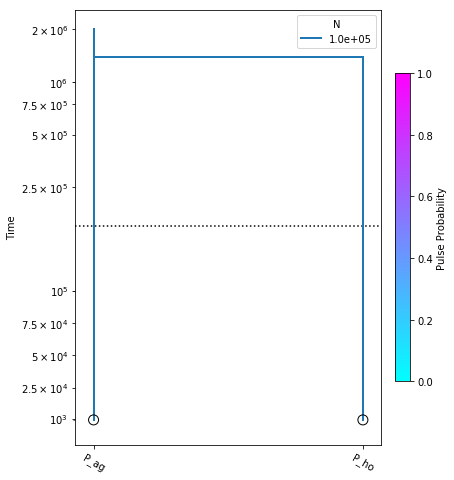

In [148]:
yticks = [1e3, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    no_migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [129]:
#pure isolation model estimate pop sizes for P. ag and P. hom
popsizes_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

popsizes_model.set_data(sfs)

popsizes_model.add_size_param("n_ag")
popsizes_model.add_size_param("n_ho")

popsizes_model.add_leaf("P_ag", N="n_ag")
popsizes_model.add_leaf("P_ho", N="n_ho")
popsizes_model.move_lineages("P_ho", "P_ag", t=1.4e6)

popsizes_model.stochastic_optimize(num_iters=2000,n_minibatches=10)
popsizes_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5948818192242777
            jac: array([-4.47029107e-07,  7.71835912e-08])
  kl_divergence: 2.5948818192242777
 log_likelihood: -187.62865605465845
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 11
            nit: 5
     parameters: ParamsDict({'n_ag': 1109711.490643479, 'n_ho': 605273.1858197119})
         status: 1
        success: True
              x: array([13.91961062, 13.31343518])

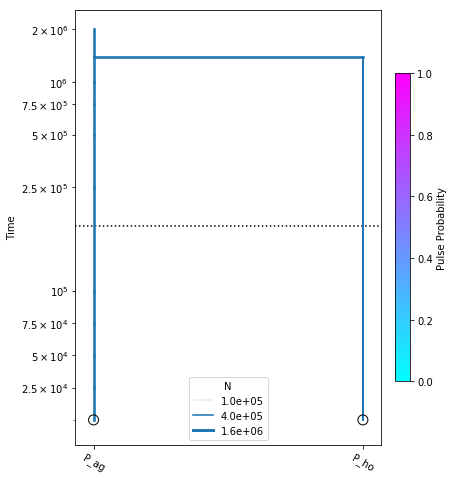

In [130]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    popsizes_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [131]:
#assymetric migration model with single pulse from aglaiae to homochrous
#because this is coalescent, pulses are modeled "backwards"
#i.e. move_lineages from ho to ag in coalescent time is equivalent to migration from ag to ho in forward time

migration_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model.set_data(sfs)

migration_model.add_time_param("tmig_ho_ag")
migration_model.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model.add_size_param("n_ag")
migration_model.add_size_param("n_ho")

migration_model.add_leaf("P_ag", N="n_ag")
migration_model.add_leaf("P_ho", N="n_ho")
migration_model.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.502111950761942
            jac: array([ 3.95001381e-07,  5.77093595e-03,  7.14167466e-03, -1.95192398e-03])
  kl_divergence: 2.502111950761942
 log_likelihood: -182.99016263154164
        message: 'Max. number of function evaluations reached'
           nfev: 100
            nit: 21
     parameters: ParamsDict({'tmig_ho_ag': 8474.26988479527, 'mfrac_ho_ag': 0.8856525327456847, 'n_ag': 79693.17029120708, 'n_ho': 3628.859539166066})
         status: 3
        success: False
              x: array([8.47426988e+03, 2.04708293e+00, 1.12859392e+01, 8.19667370e+00])

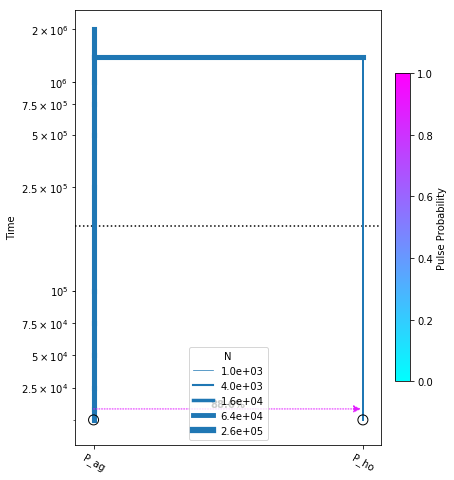

In [132]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [133]:
#assymetrical migration model 2 where pulse from hom to agl

migration_model2 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model2.set_data(sfs)

migration_model2.add_time_param("tmig_ag_ho")
#migration_model2.add_time_param("tmig_ho_ag")
migration_model2.add_pulse_param("mfrac_ag_ho", upper=1.0)
#migration_model2.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model2.add_size_param("n_ag")
migration_model2.add_size_param("n_ho")

migration_model2.add_leaf("P_ag", N="n_ag")
migration_model2.add_leaf("P_ho", N="n_ho")
migration_model2.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
#migration_model2.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model2.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model2.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model2.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5509592586203818
            jac: array([-1.28683836e-07, -9.77568901e-04,  7.36150579e-04, -3.41561546e-04])
  kl_divergence: 2.5509592586203818
 log_likelihood: -185.43252802446364
        message: 'Max. number of function evaluations reached'
           nfev: 100
            nit: 20
     parameters: ParamsDict({'tmig_ag_ho': 7431.359078312293, 'mfrac_ag_ho': 0.9767729001236279, 'n_ag': 3632.9442147486056, 'n_ho': 13237.807944266193})
         status: 3
        success: False
              x: array([7.43135908e+03, 3.73893448e+00, 8.19779868e+00, 9.49083225e+00])

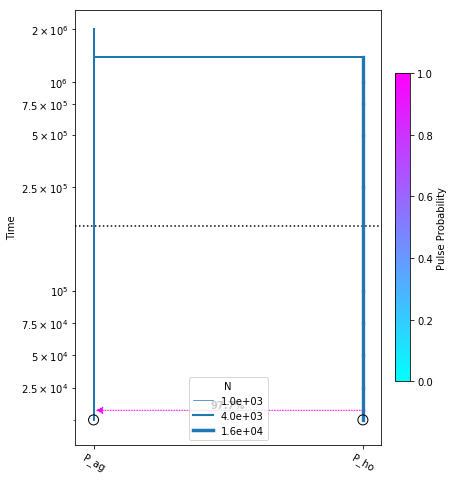

In [134]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model2, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [150]:
#ancestral migration older than start of holocene 8200 years
migration_model3 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model3.set_data(sfs)

migration_model3.add_time_param("tmig_ag_ho", upper=1e6, lower=8200)
migration_model3.add_time_param("tmig_ho_ag",upper=1e6, lower=8200)
migration_model3.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model3.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model3.add_size_param("n_ag")
migration_model3.add_size_param("n_ho")

migration_model3.add_leaf("P_ag", N="n_ag")
migration_model3.add_leaf("P_ho", N="n_ho")
migration_model3.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model3.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model3.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model3.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model3.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.4350072288613065
            jac: array([ 5.83042694e-07,  1.56928546e-08,  2.07408267e-06,  1.90612016e-07,
        2.82007905e-06, -1.00141292e-05])
  kl_divergence: 2.4350072288613065
 log_likelihood: -179.63492653650988
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 100
            nit: 19
     parameters: ParamsDict({'tmig_ag_ho': 60617.33369100726, 'tmig_ho_ag': 8200.009848007636, 'mfrac_ag_ho': 0.2017578525718169, 'mfrac_ho_ag': 0.8839103947438173, 'n_ag': 20887.135423118372, 'n_ho': 3464.7232561549454})
         status: 1
        success: True
              x: array([ -2.88598559, -18.42776286,  -1.37534377,   2.02999334,
         9.94688872,   8.15038804])

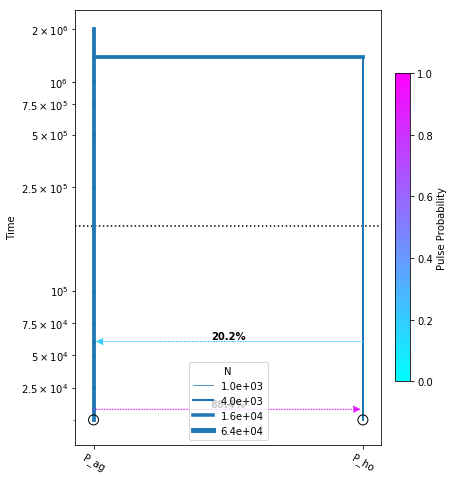

In [151]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model3, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [152]:
#secondary contact model younger than start of holocene 8200 yrs
migration_model4 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model4.set_data(sfs)

migration_model4.add_time_param("tmig_ag_ho", upper=8200, lower=100)
migration_model4.add_time_param("tmig_ho_ag",upper=8200, lower=100)
migration_model4.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model4.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model4.add_size_param("n_ag")
migration_model4.add_size_param("n_ho")

migration_model4.add_leaf("P_ag", N="n_ag")
migration_model4.add_leaf("P_ho", N="n_ho")
migration_model4.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model4.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model4.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model4.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model4.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.4826914353919007
            jac: array([ 3.17730735e-16,  4.40560047e-04,  2.00435789e-05,  1.22416266e-04,
       -9.44366893e-06,  3.98903486e-05])
  kl_divergence: 2.4826914353919007
 log_likelihood: -182.0191368630396
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 100
            nit: 20
     parameters: ParamsDict({'tmig_ag_ho': 100.00000000007529, 'tmig_ho_ag': 2278.816010546384, 'mfrac_ag_ho': 0.006770708533447837, 'mfrac_ho_ag': 0.9215471698111312, 'n_ag': 44668.39735854029, 'n_ho': 928.4574220876074})
         status: 1
        success: True
              x: array([-32.30925858,  -0.99975481,  -4.98835581,   2.46355641,
        10.70702154,   6.83352452])

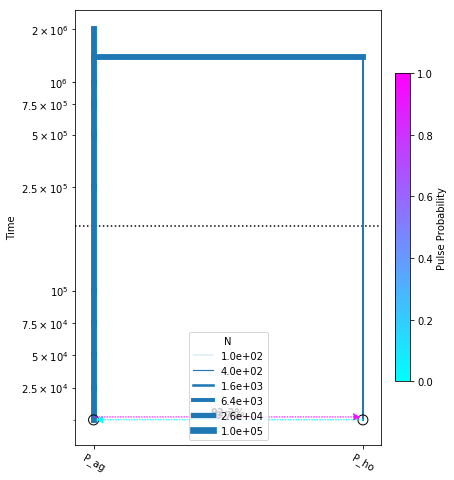

In [153]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model4, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [140]:
#continuous migration modeled as four evenly spaced bi-directional migration events at contemporary, 280, 560, 820, and 1120kya
migration_model5 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model5.set_data(sfs)

migration_model5.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho2", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag2", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho3", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag3", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho4", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag4", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho5", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag5", upper=1.0)

migration_model5.add_size_param("n_ag")
migration_model5.add_size_param("n_ho")

migration_model5.add_leaf("P_ag", N="n_ag")
migration_model5.add_leaf("P_ho", N="n_ho")

migration_model5.move_lineages("P_ag", "P_ho", t=10, p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=10, p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=280000, p="mfrac_ag_ho2")
migration_model5.move_lineages("P_ho", "P_ag", t=280000, p="mfrac_ho_ag2")

migration_model5.move_lineages("P_ag", "P_ho", t=560000, p="mfrac_ag_ho3")
migration_model5.move_lineages("P_ho", "P_ag", t=560000, p="mfrac_ho_ag3")

migration_model5.move_lineages("P_ag", "P_ho", t=840000, p="mfrac_ag_ho4")
migration_model5.move_lineages("P_ho", "P_ag", t=840000, p="mfrac_ho_ag4")

migration_model5.move_lineages("P_ag", "P_ho", t=1120000, p="mfrac_ag_ho5")
migration_model5.move_lineages("P_ho", "P_ag", t=1120000, p="mfrac_ho_ag5")

migration_model5.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model5.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model5.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5045144827520405
            jac: array([-3.12461511e-06,  1.98912329e-09, -1.27693542e-05, -3.92435068e-06,
        2.79251062e-08,  1.24526291e-08,  1.32941841e-07,  2.60648860e-08,
        2.13682893e-07,  2.12411835e-07, -5.37374506e-07, -7.98802895e-07])
  kl_divergence: 2.5045144827520405
 log_likelihood: -183.11028923104658
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 59
            nit: 11
     parameters: ParamsDict({'mfrac_ag_ho': 0.005057812589825674, 'mfrac_ho_ag': 8.157988537427066e-09, 'mfrac_ag_ho2': 0.6146053455385917, 'mfrac_ho_ag2': 0.6030067202324627, 'mfrac_ag_ho3': 2.5142923215162333e-06, 'mfrac_ho_ag3': 8.328347427117216e-07, 'mfrac_ag_ho4': 9.648303994299266e-06, 'mfrac_ho_ag4': 1.7745405591260207e-06, 'mfrac_ag_ho5': 2.285432478600046e-05, 'mfrac_ho_ag5': 2.5878057347051663e-05, 'n_ag': 180928.8664652528, 'n_ho': 127476.43957097939})
         status: 1
        success: True
              x: array([ -5.28175054, -18.624268

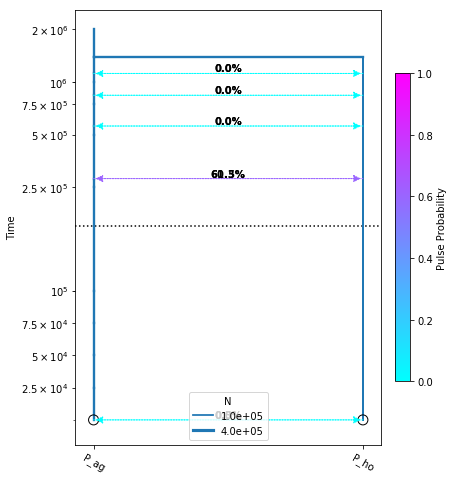

In [141]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model5, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [154]:
#repeated secondary contact model. biderctional pulse after Quaternary and pulse before Quaternary 8200 yrs ago

migration_model6 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model6.set_data(sfs)

migration_model6.add_time_param("tmig_ag_ho", upper=1e6, lower=8200)
migration_model6.add_time_param("tmig_ho_ag",upper=1e6, lower=8200)
migration_model6.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model6.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model6.add_time_param("tmig_ag_ho2", upper=8200, lower=100)
migration_model6.add_time_param("tmig_ho_ag2",upper=8200, lower=100)
migration_model6.add_pulse_param("mfrac_ag_ho2", upper=1.0)
migration_model6.add_pulse_param("mfrac_ho_ag2", upper=1.0)


migration_model6.add_size_param("n_ag")
migration_model6.add_size_param("n_ho")

migration_model6.add_leaf("P_ag", N="n_ag")
migration_model6.add_leaf("P_ho", N="n_ho")
migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho2", p="mfrac_ag_ho2")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag2", p="mfrac_ho_ag2")

migration_model6.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model6.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model6.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.4094004506306614
            jac: array([-3.05672836e-06, -4.69295762e-07,  3.19430535e-05,  3.04136368e-05,
        4.53994579e-05,  4.73732263e-05,  1.15598311e-04,  1.80563369e-04,
       -9.22279886e-06, -3.09190921e-06])
  kl_divergence: 2.4094004506306614
 log_likelihood: -178.35458762497763
        message: 'Max. number of function evaluations reached'
           nfev: 100
            nit: 18
     parameters: ParamsDict({'tmig_ag_ho': 957648.48131667, 'tmig_ho_ag': 29164.314187966305, 'mfrac_ag_ho': 0.04822451698004431, 'mfrac_ho_ag': 0.01441667216793176, 'tmig_ag_ho2': 7954.263234279443, 'tmig_ho_ag2': 107.83177677110011, 'mfrac_ag_ho2': 0.2518476539124166, 'mfrac_ho_ag2': 0.9682785030688025, 'n_ag': 1439.8510099339549, 'n_ho': 43.18278186255136})
         status: 3
        success: False
              x: array([ 3.10987699, -3.83533556, -2.98246163, -4.22484835,  3.46455085,
       -6.94046258, -1.08878227,  3.41852517,  7.27229492,  3.76544185])

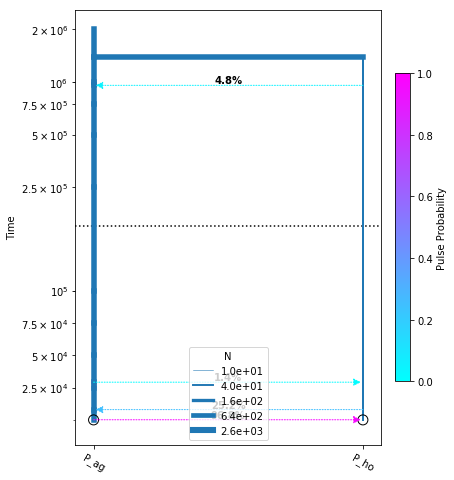

In [155]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model6, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [156]:
import numpy as np

AICs = []
for model in [popsizes_model, migration_model, migration_model2, migration_model3, migration_model4, migration_model5, migration_model6]:
    lik = model.log_likelihood()
    nparams = len(model.get_params())
    aic = 2*nparams - 2*lik
    print("AIC {}".format(aic))
    AICs.append(aic)

minv = np.min(AICs)
delta_aic = np.array(AICs) - minv
print("Delta AIC per model: ", delta_aic)
print("AIC weight per model: ", np.exp(-0.5 * delta_aic))


/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:458: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)] + [0] * len(b.pop_labels)]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

AIC 379.2573121093169
AIC 373.9803252630833
AIC 378.8650560489273
AIC 371.26985307301976
AIC 376.0382737260792
AIC 390.22057846209316
AIC 376.70917524995525
Delta AIC per model:  [ 7.98745904  2.71047219  7.59520298  0.          4.76842065 18.95072539
  5.43932218]
AIC weight per model:  [1.84308476e-02 2.57886402e-01 2.24244928e-02 1.00000000e+00
 9.21617285e-02 7.67188824e-05 6.58970839e-02]
